In [93]:
!pip install opencv-python mediapipe numpy

## Mediapipe

In [45]:
import numpy as np
import mediapipe as mp
import cv2

In [46]:
mph=mp.solutions.holistic
mpd=mp.solutions.drawing_utils

### Landmarks using Mediapipe

In [47]:
def dl(image,results):
    mpd.draw_landmarks(image,results.face_landmarks,mph.FACEMESH_TESSELATION,mpd.DrawingSpec(color=(34,234,5),thickness=1,circle_radius=1), mpd.DrawingSpec(color=(34,123,90),thickness=1,circle_radius=1))
    mpd.draw_landmarks(image,results.pose_landmarks,mph.POSE_CONNECTIONS, mpd.DrawingSpec(color=(23,5,100),thickness=2,circle_radius=3), mpd.DrawingSpec(color=(123,80,67),thickness=2,circle_radius=2))
    mpd.draw_landmarks(image,results.left_hand_landmarks,mph.HAND_CONNECTIONS,mpd.DrawingSpec(color=(90,78,56),thickness=2,circle_radius=4), mpd.DrawingSpec(color=(34,123,90),thickness=2,circle_radius=2))
    mpd.draw_landmarks(image,results.right_hand_landmarks,mph.HAND_CONNECTIONS, mpd.DrawingSpec(color=(67,34,90),thickness=2,circle_radius=4), mpd.DrawingSpec(color=(23,4,56),thickness=2,circle_radius=2))


In [80]:
mpd.draw_landmarks??

Signature:
mpd.draw_landmarks(
    image: numpy.ndarray,
    landmark_list: mediapipe.framework.formats.landmark_pb2.NormalizedLandmarkList,
    connections: Optional[List[Tuple[int, int]]] = None,
    landmark_drawing_spec: Union[mediapipe.python.solutions.drawing_utils.DrawingSpec, Mapping[int, mediapipe.python.solutions.drawing_utils.DrawingSpec], NoneType] = DrawingSpec(color=(0, 0, 255), thickness=2, circle_radius=2),
    connection_drawing_spec: Union[mediapipe.python.solutions.drawing_utils.DrawingSpec, Mapping[Tuple[int, int], mediapipe.python.solutions.drawing_utils.DrawingSpec]] = DrawingSpec(color=(224, 224, 224), thickness=2, circle_radius=2),
    is_drawing_landmarks: bool = True,
)
Source:   
def draw_landmarks(
    image: np.ndarray,
    landmark_list: landmark_pb2.NormalizedLandmarkList,
    connections: Optional[List[Tuple[int, int]]] = None,
    landmark_drawing_spec: Optional[
        Union[DrawingSpec, Mapping[int, DrawingSpec]]
    ] = DrawingSpec(color=RED_COLOR),

In [48]:
def detection(image,model):
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image.flags.writeable=False
    results=model.process(image)
    image.flags.writeable=True
    image=cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
    return image,results

### register keypoints

In [49]:
def ekeypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
    left_hand = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(63)
    right_hand = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(63)
    return np.concatenate([pose,face,left_hand,right_hand])

### list of words to be detected

In [50]:
signs=["I", "help", "please", "want", "more"]

In [81]:
len(signs)

5

In [51]:
import os

In [52]:
PATH_DIR = os.path.join('Dataset') 

In [ ]:
os.path.exists(PATH_DIR)

### Dataset Collection

In [53]:
actions = np.array(signs) 
total_number_of_sequences = 30
frame_length = 30

for sign in signs:
    for sequence in range(total_number_of_sequences):
        try:
            os.makedirs(os.path.join(PATH_DIR,sign,str(sequence)))
        except:
            pass


In [82]:
os.path.exists(PATH_DIR)

True

### Creating a `progress.json` File to Capture the History of Recorded Signs and Frames
#### Preventing Data Loss During Interruptions


In [83]:
import json

In [84]:
BASE_DIRECTORY = 'Dataset'
PROGRESS_FILE = os.path.join(BASE_DIRECTORY, 'progress.json')

In [85]:
def load_progress():
    if os.path.exists(PROGRESS_FILE):
        with open(PROGRESS_FILE, 'r') as f:
            return json.load(f)
    return {'sign': None, 'sequence': 0, 'frame': 0,'sign_index':0}

In [86]:
def save_progress(progress):
    with open(PROGRESS_FILE, 'w') as f:
        json.dump(progress, f)

## DATA COLLECTION

In [ ]:
capture = cv2.VideoCapture(0)

with mph.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as model:

    progress = load_progress()
    start_sign = progress.get('sign', None)
    start_sequence = progress.get('sequence', 0)
    start_frame = progress.get('frame', 0)
    start_index = progress.get('sign_index', 0)
    

    for i, sign in enumerate(signs[start_index:], start=start_index):
        if sign == start_sign:
            sequence_start = start_sequence
        else:
            sequence_start = 0

        for sequence in range(sequence_start, total_number_of_sequences):
            if sign == start_sign and sequence == start_sequence:
                frame_start = start_frame
            else:
                frame_start = 0

            for fnum in range(frame_start, frame_length):
                ret, frame = capture.read()
                if not ret:
                    break
                
                image, results = detection(frame, model)
                dl(image, results)

                if fnum == 0:
                    cv2.putText(image, 'DATASET COLLECTING', (120, 200),
                                cv2.FONT_HERSHEY_TRIPLEX, 1, (0, 255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting dataset {} Video Number {} frame number {}'.format(sign, sequence, fnum), (15, 12),
                                cv2.FONT_HERSHEY_TRIPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.imshow('Sign Language Recognition', image)
                    cv2.waitKey(1000)
                else:
                    cv2.putText(image, 'Collecting dataset {} Video Number {} frame number {}'.format(sign, sequence, fnum), (15, 12),
                                cv2.FONT_HERSHEY_TRIPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.imshow('Sign Language Recognition', image)

                keypoints = ekeypoints(results)
                npy_file = os.path.join(PATH_DIR, sign, str(sequence), str(fnum))
                np.save(npy_file, keypoints)

                
                save_progress({'sign': sign, 'sequence': sequence, 'frame': fnum, 'sign_index': i})

                key = cv2.waitKey(1) & 0xFF
                if key == ord('q'):
                    print(f"Quitting... Progress saved. Last processed sign: '{sign}', sequence: {sequence}, frame: {fnum}")
                    break
            if key == ord('q'):
                break
        if key == ord('q'):
            break

    capture.release()
    cv2.destroyAllWindows()


##### for force shutdown

In [87]:
capture.release()
cv2.destroyAllWindows()

In [95]:
!pip install tensorflow scikit-learn

### PROPROCESSING

In [54]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [55]:
label_map = {label:num for num, label in enumerate(actions)}

In [56]:
label_map

{'I': 0, 'help': 1, 'please': 2, 'want': 3, 'more': 4}

In [57]:
frame_length

30

In [58]:
sequences, labels = [], []
for action in actions:
    for sequence in range(total_number_of_sequences):
        window = []
        for frame_num in range(frame_length):
            res = np.load(os.path.join(PATH_DIR, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [59]:
X = np.array(sequences)

In [60]:
X.shape

(150, 30, 1662)

In [61]:
y = to_categorical(labels).astype(int)

In [62]:
y.shape

(150, 5)

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [64]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [65]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [66]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

c:\Users\Asus\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [67]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [68]:
model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

Epoch 1/2000
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - categorical_accuracy: 0.1528 - loss: 1.6244
Epoch 2/2000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - categorical_accuracy: 0.2090 - loss: 1.7290
Epoch 3/2000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - categorical_accuracy: 0.1723 - loss: 1.5373
Epoch 4/2000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - categorical_accuracy: 0.4300 - loss: 1.3734
Epoch 5/2000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - categorical_accuracy: 0.5748 - loss: 1.1080
Epoch 6/2000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - categorical_accuracy: 0.6518 - loss: 1.0924
Epoch 7/2000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - categorical_accuracy: 0.5592 - loss: 1.2722
Epoch 8/2000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - categorical_accuracy: 0.5266 - loss: 1.2086
Epoch 9/2000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - categorical_accuracy: 0.6448 - loss: 1.0628
Epoch 10/2000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - categorical_accuracy: 0.4867 - loss: 1.0578
Epoch 11/2000
5/5 ━━━━━━━━━━━

KeyboardInterrupt: 

In [69]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 30, 64)         │       442,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 30, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,790,225 (6.83 MB)

 Trainable params: 596,741 (2.28 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,193,484 (4.55 MB)

In [70]:
res = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step


In [71]:
model.save('action.h5')

if error pls use
`del model`

In [72]:
model.load_weights('action.h5')

In [73]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [74]:
yhat = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


In [75]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [76]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[7, 0],
        [0, 1]],

       [[6, 0],
        [0, 2]],

       [[4, 0],
        [0, 4]],

       [[7, 0],
        [0, 1]]], dtype=int64)

In [77]:
accuracy_score(ytrue, yhat)

1.0

In [96]:
!pip install matplotlib

In [90]:
import matplotlib.pyplot as plt

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

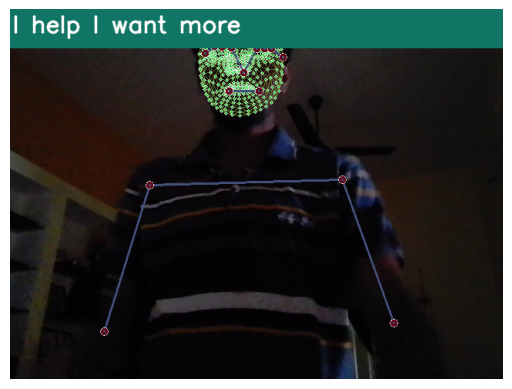

In [92]:
sequence = []
sentence = []
threshold = 0.8
cap = cv2.VideoCapture(0)
with mph.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        image, results = detection(frame, holistic)
        print(results)
        dl(image, results)
        keypoints = ekeypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            if res[np.argmax(res)] > threshold: 
                if len(sentence) > 0: 
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:] 
        cv2.rectangle(image, (0,0), (800, 50), (100, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        cv2.imshow('Pride Project Output Window', image)
        
        if cv2.waitKey(10) & 0xFF == ord('q'):
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    

            plt.imshow(image_rgb)
            plt.axis('off') 
            plt.show()
            break

    cap.release()
    cv2.destroyAllWindows()

In [88]:
cap.release()
cv2.destroyAllWindows()